In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import plotly
import plotly.graph_objects as go
import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary
import torch
import torchmetrics
from torch.utils.data import DataLoader, Dataset, TensorDataset

---
First, we need to take a bunch of images, resize them to the same size without distorting (so we'll use padding).

In [3]:
#Open image into an 'image' object type
def im_to_vec(file,size=128):
    im_vec = (Image.open(file))
    #calculate height and width
    width, height = (im_vec.size[0]),im_vec.size[1]
    if width > height:
        #calc ratio for resize
        h_c = width/height
        im_vec = im_vec.resize((size,int(size/h_c)))
        #recalculate to get pad values
        width, height = (im_vec.size[0]),im_vec.size[1]
        height_total_pad = width-height
        height_pad_l = int(height_total_pad/2)
        height_pad_r = int((height_total_pad+1)/2)
        im_vec=np.pad(im_vec,pad_width=((height_pad_l,height_pad_r),(0,0),(0,0)))
    elif height > width:
        #resize
        w_c = height/width
        im_vec = im_vec.resize((int(size/w_c),size))
        #pad
        width, height = (im_vec.size[0]),im_vec.size[1]
        width_pad = height-width
        width_pad_l = int(width_pad/2)
        width_pad_r = int((width_pad+1)/2)
        im_vec=np.pad(im_vec,pad_width=((0,0),(width_pad_l,width_pad_r),(0,0)))
    else:
        im_vec = im_vec.resize((size,size))
    
    #Pad it out to a full 128 by 128
    return im_vec

Shape of image is: (128, 128, 3)


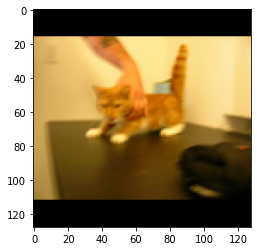

In [4]:
im = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Cat/0.jpg'
im = im_to_vec(im)
print(f'Shape of image is: {im.shape}')
plt.imshow(im)
plt.show()

---
Script to convert all the files

In [5]:
def convert_all_ims_one_array(size, dir_dog, dir_cat,max_im):

    x=np.zeros((25000,size,size,3)).astype(np.uint8)
    dog_length=0
    cat_length=0

    for idx, image in enumerate((os.listdir(dir_dog))[:max_im]):
        try:
            x[idx] = im_to_vec(f'{dir_dog}/{image}',size=size)
            dog_length+=1

        except:
            continue

    for idx, image in enumerate((os.listdir(dir_cat))[:max_im]):
        try:
            x[dog_length+idx] = im_to_vec(f'{dir_cat}/{image}',size=size)
            cat_length+=1

        except:
            continue
            
    y=np.append(np.zeros((dog_length)),np.ones(cat_length))
    x = x[:len(y)]
    print(cat_length)
    return x, y


In [294]:
dir_dogs = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Dog'
dir_cat = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Cat'
size=64
x,y = convert_all_ims_one_array(size, dir_dogs, dir_cat,max_im=10000)

9971


In [295]:
x.shape,len(y)

((19936, 64, 64, 3), 19936)

---
EigenVectors

We are going to reduce the dimensionality of our dataset(currently 128x128) by using eigenvectors. This will allow us to capture the most important variations between images. We will then see if we can apply just this reduced number of dimensions to a neural net and gain a similar performance level to that which we achieved with a ResNet on the full images (~85%)

Steps: 

1- Flatten arrays 

2- normalize data across each dimension

3- Compute N eigenvectors and the covariance matrix


4- Project images onto eigenspace using projection matrix:  

- projection = B @ (B.T@B)^-1 @ B.T } 

where B is new basis. B.T@B will be the identity matrix if the eigenvectors are normalised, so it would just become:

- projection = B @ B.T

We will experiment with various choices of N, but 20 is a good place to start

In [367]:
import tempfile

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [22]:
x = x_train[:30000]
y = y_train[:30000]

In [23]:
x_flat = x.reshape(x.shape[0],-1)
x = (x_train_part/255)

In [7]:
#get data into a data object and then create the batches
def create_dataloaders(x,y,batch_size):
    tensor_x = torch.Tensor(x) # transform to torch tensor
    tensor_y = torch.Tensor(y)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_data, val_data = torch.utils.data.random_split(my_dataset, [int(0.8*len(y)), len(y)-int(0.8*len(y))])
    train_dataloader = DataLoader(train_data,batch_size=batch_size)
    val_dataloader = DataLoader(val_data,batch_size=batch_size) 
    return train_dataloader, val_dataloader


In [105]:
#create sequential model
class seven_layer_model(torch.nn.Module):
    """don't think we need to do super() because we aren't doing a separate init"""
    def __init__(self,inputdim=50):
        super().__init__()
        self.tanh = torch.nn.Tanh()
        self.batch1 = torch.nn.BatchNorm1d(100)
        self.batch2 = torch.nn.BatchNorm1d(100)
        self.batch3 = torch.nn.BatchNorm1d(100)
        self.batch4 = torch.nn.BatchNorm1d(100)

        self.layer1 = torch.nn.Linear(inputdim,100)
        self.layer2 = torch.nn.Linear(100,100)
        self.layer3 = torch.nn.Linear(100,100)
        self.layer4 = torch.nn.Linear(100,100)
        
        self.layer5 = torch.nn.Linear(100,10)        
        self.softmax = torch.nn.Softmax(dim=1)
        for layer in self.parameters():
            if layer == torch.nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)

    def forward(self,x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.batch1(x)
        x2 = self.layer2(x)
        x2 = self.tanh(x)
        x2 = self.batch2(x)
        x3 = self.batch3(self.tanh(self.layer3(x)))
        x4 = self.batch4(x2 + self.tanh(self.layer4(x)))
        x5 = self.layer5(x4)
        output = self.softmax(x5)
        return output


#create forward pass and backward pass
def train_step(model, dataloader, criterion,optimizer, accuracy_metric, printy=True):
    model.train()
    for x,y in dataloader:
        outputs = model(x)
        y = y.long()
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predictions = torch.argmax(outputs,axis=-1)
        accuracy_metric(outputs,y)

    acc = accuracy_metric.compute()

    if printy:
        print('Train Accuracy: ', acc)
    accuracy_metric.reset()

def val_step(model, dataloader,accuracy_metric):
    model.eval()
    with torch.no_grad():
        for x,y in dataloader:
            outputs = model(x)
            y = y.long()
            predictions = torch.argmax(outputs,axis=-1)

            accuracy_metric(outputs,y)

        acc = accuracy_metric.compute()
    print('Val Accuracy: ', acc)
    accuracy_metric.reset()
def train_model(model,train_dataloader,val_dataloader, criterion, optimizer, accuracy_metric, epochs,progress=True):
    for epoch in range(epochs):
        
        if progress==True and epoch in np.geomspace(1,60,20).astype('int'):
            print(f'epoch: {epoch}')
            train_step(model,train_dataloader, criterion, optimizer, accuracy_metric)
            val_step(model, val_dataloader,accuracy_metric)
        else:
            train_step(model,train_dataloader,criterion, optimizer, accuracy_metric,printy=False)
    print(f'End of Model results after {epoch} epochs:')
    train_step(model,train_dataloader, criterion, optimizer, accuracy_metric)    
    val_step(model, val_dataloader,accuracy_metric)

In [10]:
train_dataloader, val_dataloader = create_dataloaders(x, y, 200)
#define metrics.
accuracy_metric = torchmetrics.Accuracy()

pre_eig_model = seven_layer_model(inputdim=x.shape[1])

#create optimizer - which includes the model as a parameter
optimizer = torch.optim.Adam(pre_eig_model.parameters())

#create criterion
criterion = torch.nn.CrossEntropyLoss()

In [532]:
train_model(pre_eig_model, train_dataloader, val_dataloader, criterion, optimizer, accuracy_metric, epochs=65)

epoch: 2
Train Accuracy:  tensor(0.8873)
Val Accuracy:  tensor(0.8915)
epoch: 5
Train Accuracy:  tensor(0.9238)
Val Accuracy:  tensor(0.9249)
epoch: 17
Train Accuracy:  tensor(0.9650)
Val Accuracy:  tensor(0.9651)
epoch: 64
Train Accuracy:  tensor(0.9863)
Val Accuracy:  tensor(0.9862)


----
Small comparison to sequential

In [528]:
seq_model = torch.nn.Sequential(torch.nn.Linear(X.shape[1],100),torch.nn.ReLU(),
                               torch.nn.Linear(100,100),torch.nn.ReLU(),
                               torch.nn.Linear(100,200),torch.nn.ReLU(),
                               torch.nn.Linear(200,160),torch.nn.ReLU(),
                               torch.nn.Linear(160,10), torch.nn.Softmax())
criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')  ### calcualte the loss
seq_optimizer = torch.optim.SGD(seq_model.parameters(),lr=0.1,momentum=0.9)
train_model(seq_model, train_dataloader, val_dataloader, criterion, seq_optimizer, accuracy_metric, epochs=51,progress=False)

epoch: 2
Train Accuracy:  tensor(0.9051)
Val Accuracy:  tensor(0.9045)
epoch: 5
Train Accuracy:  tensor(0.9020)
Val Accuracy:  tensor(0.9019)
epoch: 17
Train Accuracy:  tensor(0.9035)
Val Accuracy:  tensor(0.9035)


---

OK, so we are achieving 98% accuracy with a simple 5 layer neural network with batch norm.

Now let's perform eigendecomposition and see if a reduced set of features can give us the same

In [50]:
def create_eigs(x):
    #normalize data
    def normalize_data(x):
        x = x.reshape(x.shape[0],-1)
        mean, var = np.mean(x,axis=0), np.var(x,axis=0)
        x = (x-mean)/np.sqrt(var+1e-7)
        return x
    
    x = normalize_data(x)

    def create_eigenvectors(x):
        cov_matrix = np.cov(x,rowvar=False)
        eig_val, eig_vec = np.linalg.eig(cov_matrix)
        return eig_val, eig_vec, cov_matrix
       
    eig_val,eig_vec, cov_matrix = create_eigenvectors(x)
    return eig_val, eig_vec, cov_matrix

def project_X(eig_vec,x,eigs):
    prin_eig_vec, prin_eig_val = eig_vec[:,:eigs], eig_val[:eigs]
    P = prin_eig_vec @ prin_eig_vec.T

    #project onto all prev_dims
    projection_prev_dims = (P @ x.T).T
    #project in terms of new dims
    projection_eig_dims = x @ prin_eig_vec
    return projection_eig_dims, projection_prev_dims, P

In [87]:
cov_matrix.shape

(784, 784)

In [79]:
eig_val, eig_vec, cov_matrix = create_eigs(x_flat)
projection_eig_dims, projection_prev_dims, P = project_X(eig_vec, x_flat, 50)
projection_eig_dims = projection_eig_dims / 255

In [80]:
print(f'Projection matrix is of shape: {P.shape}\nDimensions of projected values on old space: {projection_prev_dims.shape}\nprojection in terms of eigenbases: {projection_eig_dims.shape}')

Projection matrix is of shape: (784, 784)
Dimensions of projected values on old space: (30000, 784)
projection in terms of eigenbases: (30000, 50)


---
what does a projection 'look' like - turns out like nothing at all really

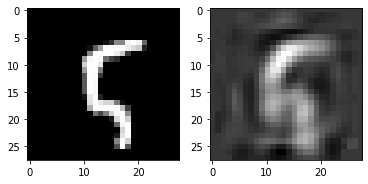

In [81]:
example = 100
fig, axlist = plt.subplots(nrows=1,ncols=2)
axlist[0].imshow(x_train_part[example],cmap='gray'); 
axlist[1].imshow(1*projection_prev_dims[example].astype(float).reshape(28,28),cmap='gray'); plt.show()

--- 
The eigenbases also don't look like much

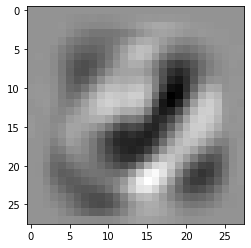

In [82]:
#scaled up eigenvectors
plt.imshow(100*prin_eig_vec[:,5].astype(float).reshape(28,28),cmap='gray')

----

So now let's create a dataset which is the projection of the X values into the top 50 eigenbases (note, all the relevant info is contained in the array with just 50 columns), and see how this performs in our dense network

In [83]:
#dataset
train_data_eig, val_data_eig = create_dataloaders(projection_eig_dims, y,batch_size=200)
#create model with new inputdim
eigenmodel_50 = seven_layer_model(inputdim=projection_eig_dims.shape[1])

#create optimizer linked to this model
optimizer_eig = torch.optim.Adam(eigenmodel_50.parameters())

In [84]:
train_model(eigenmodel_50,train_data_eig, val_data_eig, criterion, optimizer_eig, accuracy_metric, epochs=50,progress=False)

End of Model results after 49 epochs:
Train Accuracy:  tensor(0.7965)
Val Accuracy:  tensor(0.7965)


---
We aren't able to achieve quite as strong performance when we have only 50 dimensions. Let's see what happens if we try more / less eigenvectors

In [108]:
list_of_eig_n_to_try = [1,2,5,10,25,50,100,200]
eig_val, eig_vec, cov_matrix = create_eigs(x_flat)

for n in list_of_eig_n_to_try:
    print(f'\nTrying {n} eigenbases:')
    
    projection_eig_dims, projection_prev_dims, P = project_X(eig_vec, x_flat, n)
    projection_prev_dims = projection_prev_dims / 255
    print(f'x has shape {projection_eig_dims.shape}')
    
    
    #dataset
    train_data_eig, val_data_eig = create_dataloaders(projection_eig_dims, y,batch_size=1000)
    
    #create model with new inputdim
    eigenmodel_n = seven_layer_model(inputdim=projection_eig_dims.shape[1])

    #acc
    accuracy_metric = torchmetrics.Accuracy()
    #create optimizer linked to this model
    optimizer_eig = torch.optim.Adam(eigenmodel_n.parameters())
    train_model(eigenmodel_n,train_data_eig, val_data_eig, criterion, optimizer_eig, accuracy_metric, epochs=51,progress=False)


Trying 1 eigenbases:
x has shape (30000, 1)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.3035)
Val Accuracy:  tensor(0.3075)

Trying 2 eigenbases:
x has shape (30000, 2)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.3090)
Val Accuracy:  tensor(0.3130)

Trying 5 eigenbases:
x has shape (30000, 5)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.7583)
Val Accuracy:  tensor(0.7253)

Trying 10 eigenbases:
x has shape (30000, 10)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.9148)
Val Accuracy:  tensor(0.8895)

Trying 25 eigenbases:
x has shape (30000, 25)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.9505)
Val Accuracy:  tensor(0.9270)

Trying 50 eigenbases:
x has shape (30000, 50)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.9584)
Val Accuracy:  tensor(0.9393)

Trying 100 eigenbases:
x has shape (30000, 100)
End of Model results after 50 epochs:
Train Accuracy:  tensor(0.9655)
Val A